# Villin

In [1]:
import sys
import math
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display
import multiprocessing

/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.2.
  .format(latest=latest, current=current), category=UserWarning)


## Auxiliary functions

In [16]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list, tAB_interval=None):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    if tAB_interval is not None:
        ax1.set_ylim(tAB_interval[0],tAB_interval[1])
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

def rmsd_of_cluster(cluster, rmsd, dtraj):
    rmsd_list=[]
    for i,element in enumerate(rmsd):
        if dtraj[i] in cluster:
            rmsd_list.append(element)
    length = len(rmsd_list)
    
    if length == 0:
        return None

    return sum(rmsd_list)/length



color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']
color_sequence+=color_sequence


def cdf(pmf):
    mycdf=[]
    tot = 0
    for element in pmf:
        tot+= element
        mycdf.append(tot)
    return np.array(mycdf)



def confindence_interval_cdf(populations, totCounts, conf_interval=0.95, n_samples=100000):
    counts = np.round(np.array(populations)*totCounts)
    partialCounts = sum(counts)
    myarray = list(counts)#+[totCounts-partialCounts]
    s=np.random.dirichlet(myarray,n_samples)

    s_cdf = []

    for line in s:
        s_cdf.append(cdf(line))
    s_cdf = np.array(s_cdf)

    s = np.transpose(s)
    s_cdf = np.transpose(s_cdf)

    minval = []
    maxval = []
    minvalcdf = []
    maxvalcdf = []

    for line in s:
        sorted_line = np.sort(line)
        minval.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxval.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])

    for line in s_cdf:
        sorted_line = np.sort(line)
        minvalcdf.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxvalcdf.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])
    
    return minvalcdf[:-1], maxvalcdf[:-1]

## Reading Data

In [3]:
dtrajs=np.load("../vamp_scoring/automatic_eigenvalue/villin/dtrajs_villin_lag10ns.npy")

# Unfolded
stateA=[1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 59, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]

# Folded
stateB=[0, 5, 24, 55, 61, 64, 77, 92]

## MSM estimation

In [6]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

### MFPTS

In [7]:
dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

## Empirical and NM (haMSM) estimates

In [8]:
def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

In [9]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 232/232
Number of A->B/B->A  events: 122/122
Number of A->B/B->A  events: 86/86
Number of A->B/B->A  events: 75/75
Number of A->B/B->A  events: 60/60
Number of A->B/B->A  events: 43/43
Number of A->B/B->A  events: 40/40
Number of A->B/B->A  events: 38/38
Number of A->B/B->A  events: 17/17
Number of A->B/B->A  events: 8/8
Number of A->B/B->A  events: 5/5
Number of A->B/B->A  events: 5/4


In [10]:
np.save('villin_empirical_mfptsAB', empirical_mfptsAB)
np.save('villin_empirical_mfptsBA', empirical_mfptsBA)
np.save('villin_std_errAB', std_errAB)
np.save('villin_std_errBA', std_errBA)
np.save('villin_nm_mfptsAB', nm_mfptsAB)
np.save('villin_nm_mfptsBA', nm_mfptsBA)
np.save('villin_nm_hist10ns_mfptsAB', nm_hist10ns_mfptsAB)
np.save('villin_nm_hist10ns_mfptsBA', nm_hist10ns_mfptsBA)
np.save('villin_nm_hist100ns_mfptsAB', nm_hist100ns_mfptsAB)
np.save('villin_nm_hist100ns_mfptsBA', nm_hist100ns_mfptsBA)

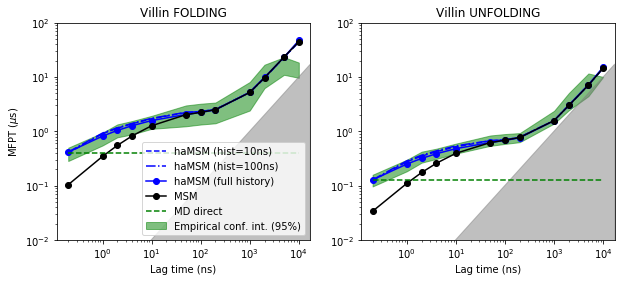

In [14]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Villin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='lower right')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Villin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)

plt.savefig('villin_mfpts.png', dpi=300)
plt.savefig('villin_mfpts.pdf')
plt.show()

## Markov + Color : History Analysis (Lag=1tau)

In [8]:
dt =0.0002

discrete_traj = dtrajs

history = np.array([0, 1, 10, 50, 100, 200, 300, 400, 500])
mpc_mfptsAB = []
mpc_mfptsBA = []

for hist in history:
    model = MarkovPlusColorModel(discrete_traj, stateA, stateB, hist_length=hist)
    kinetics = model.mfpts()
    mpc_mfptsAB.append(kinetics['mfptAB']*dt)
    mpc_mfptsBA.append(kinetics['mfptBA']*dt)

# Empirical values:
emp_mfpts = model.empirical_mfpts()

emp_mfptAB = emp_mfpts['mfptAB']*dt
emp_mfptBA = emp_mfpts['mfptBA']*dt
emp_std_err_mfptAB = emp_mfpts['std_err_mfptAB']*dt
emp_std_err_mfptBA = emp_mfpts['std_err_mfptBA']*dt

Number of A->B/B->A  events: 232/232


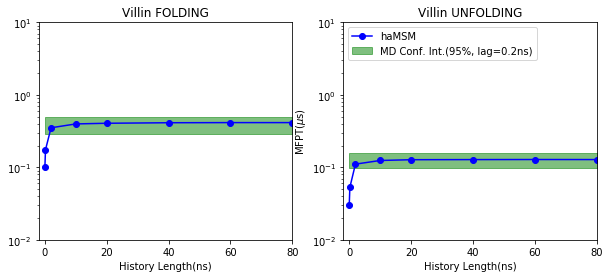

In [9]:
alpha = 0.5

fig =plt.figure(figsize = (10,4))

err_maxAB = [emp_mfptAB + 2*emp_std_err_mfptAB for _ in history]
err_minAB = [emp_mfptAB - 2*emp_std_err_mfptAB for _ in history]
err_maxBA = [emp_mfptBA + 2*emp_std_err_mfptBA for _ in history]
err_minBA = [emp_mfptBA - 2*emp_std_err_mfptBA for _ in history]



ax1 = fig.add_subplot(121, sharey=ax1)
ax1.fill_between(history*0.2, err_minBA, err_maxBA,
                 alpha=alpha, color="green", label="Conf. Int.(95%)" )
ax1.plot(history*0.2, mpc_mfptsBA, "-o", label="Markov+Color", color='b')
ax1.set_yscale("log")
ax1.set_title("Villin FOLDING")
ax1.set_xlabel("History Length(ns)")
#ax1.legend(loc='upper left')
ax1.set_xlim(-2,80)
ax1.set_ylim(0.01,10)


ax2 = fig.add_subplot(122)
ax2.fill_between(history*0.2, err_minAB, err_maxAB,
                 alpha=alpha, color="green", label="MD Conf. Int.(95%, lag=0.2ns)" )
ax2.plot(history*0.2, mpc_mfptsAB, "-o", label="haMSM", color='b')
ax2.set_yscale("log")
ax2.set_title("Villin UNFOLDING")
ax2.set_xlabel("History Length(ns)")
ax2.set_ylabel("MFPT($\mu$s)")
ax2.legend(loc='upper left')
ax2.set_xlim(-2,80)
ax2.set_ylim(0.01,10)

plt.show()

## First Passage Time Distribution

In [4]:
nm_model2 = NonMarkovModel(dtrajs, stateA, stateB)
nm_model2.mfpts() ## This values has to be multiplied by dt = 0.2ns

{'mfptAB': 2069.555555519205, 'mfptBA': 638.0130293445028}

In [11]:
lag_to_use_fptd = [1, 10, 100, 1000]

In [5]:
#fptdAB = nm_model2.fpt_distrib_AB(max_x=5000, dt=0.2)  # Computes the analytic dist. up to 5000 lag times
#fptdBA = nm_model2.fpt_distrib_BA(max_x=10000, dt=0.2)
empiric_fptsAB, empiric_fptsBA, tb_values = nm_model2.empirical_fpts()

In [13]:
#Markov densities
nm_model2.markovian=True

markov_fptdAB_list=[]
markov_fptdBA_list=[]

for lag in lag_to_use_fptd:
    nm_model2.lag_time=lag
    markov_fptdAB_list.append(nm_model2.fpt_distrib_AB(max_x=5000, dt=0.2))
    markov_fptdBA_list.append(nm_model2.fpt_distrib_BA(max_x=10000, dt=0.2))

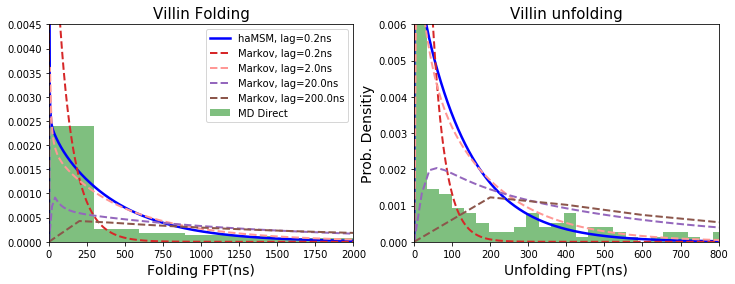

In [14]:
fig =plt.figure(figsize = (12,4))

ax1 = fig.add_subplot(121)
ax1.plot(*fptdBA.T,label='haMSM, lag=0.2ns',lw=2.5, color='b')

for i, density in enumerate(markov_fptdBA_list):
    ax1.plot(*density.T,'--', linewidth=2.0, color=color_sequence[i],
             label='Markov, lag={}ns'.format(lag_to_use_fptd[i]*0.2) )

ax1.hist(np.array(empiric_fptsBA)*0.2, normed=True, bins=20, label='MD Direct', color='green', alpha=0.5)
ax1.set_xlabel("Folding FPT(ns)", fontsize=14)
ax1.set_xlim([0,2000])
ax1.set_ylim(0,0.0045)
ax1.set_title('Villin Folding', fontsize=15)
ax1.legend()


ax2 = fig.add_subplot(122)
ax2.plot(*fptdAB.T,label='haMSM, lag=0.2ns', color='b',lw=2.5)

for i, density in enumerate(markov_fptdAB_list):
    ax2.plot(*density.T,'--', linewidth=2.0, color=color_sequence[i],
             label='Markov, lag={}ns'.format(lag_to_use_fptd[i]*0.2) )



ax2.hist(np.array(empiric_fptsAB)*0.2, normed=True, bins=50, label='MD Direct', color='green', alpha=0.5)
ax2.set_ylabel("Prob. Densitiy", fontsize=14)
ax2.set_xlabel("Unfolding FPT(ns)", fontsize=14)
ax2.set_xlim([0,800])
ax2.set_ylim(0,0.006)
ax2.set_title('Villin unfolding', fontsize=15)

fig.tight_layout

plt.show()

## Event duration ($t_b$)

###  Average $t_b$ = 6.57ns

###  Median $t_b$ = 2.20ns

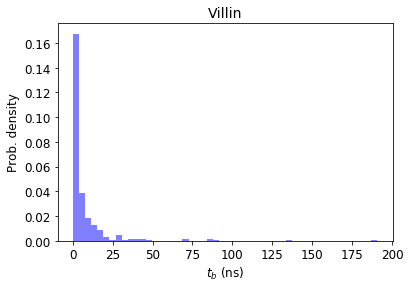

In [36]:
printmd("###  Average $t_b$ = {:.2f}ns".format(0.2*sum(tb_values)/len(tb_values)))
printmd("###  Median $t_b$ = {:.2f}ns".format(0.2*np.median(tb_values)))

plt.hist(np.array(tb_values)*0.2, normed=True, bins=50, color='blue', alpha=0.5)
plt.xlabel("$t_b$ (ns)", fontsize=12)
plt.ylabel("Prob. density", fontsize=12)
#plt.xlim([0,50])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Villin', fontsize=14)

plt.savefig('villin_event_dur.png', dpi=300)
plt.savefig('villin_event_dur.pdf')
plt.show()

## Correlation functions

In [16]:
times =  range(400, 20000, 400)
times_in_us = np.array(times)*0.0002

emp_coorAB = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateB, times=times)
emp_coorAA = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateA, times=times)
emp_coorBB = nm_model.empirical_corr_function(nm_model.stateB, nm_model.stateB, times=times)

                                              LAG TIME: 0.2ns


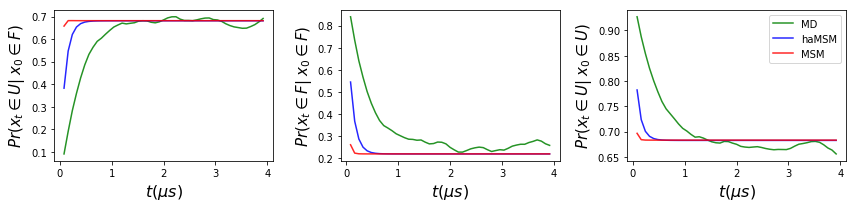

                                              LAG TIME: 2.0ns


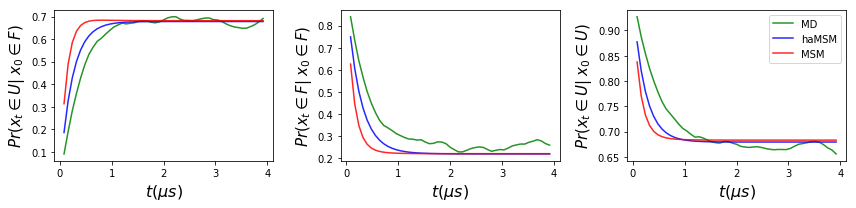

                                              LAG TIME: 10.0ns


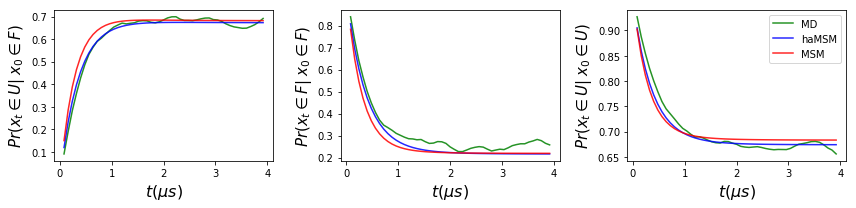

                                              LAG TIME: 20.0ns


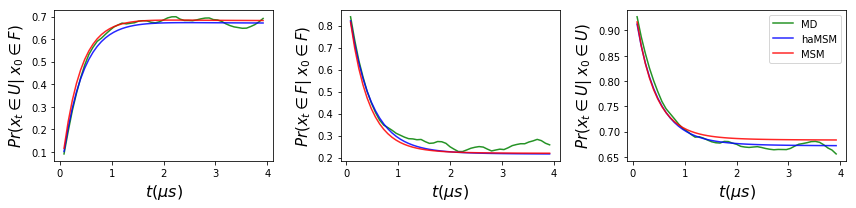

                                              LAG TIME: 40.0ns


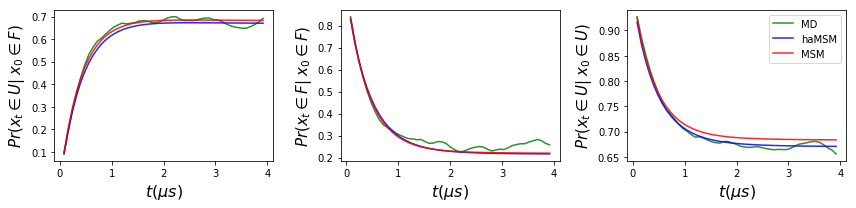

                                              LAG TIME: 80.0ns


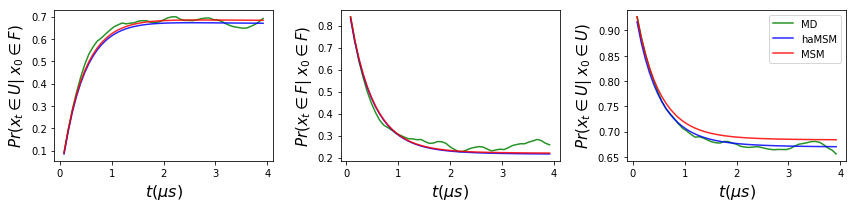

In [17]:
pA = nm_model.popA
pB = nm_model.popB

alpha = 0.85

for lag in [1, 10, 50, 100, 200, 400]:

    nm_model.lag_time=lag
    print(46*' ' + 'LAG TIME: {}ns'.format(lag*0.2))

    nm_pAA, nm_pAB, nm_pBA, nm_pBB = nm_model.corr_function(times=times)
    
    nm_model.markovian = True
    msm_pAA, msm_pAB, msm_pBA, msm_pBB = nm_model.corr_function(times=times)
    nm_model.markovian = False

    fig = plt.figure(figsize=(12,3))
    fig.add_subplot(131)
    plt.plot(times_in_us, emp_coorAB/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAB/pA, label='haMSM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAB/pA, label='MSM', color='red', alpha=alpha)
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in U|\; x_0 \in F)$', fontsize=15)

    fig.add_subplot(132)
    plt.plot(times_in_us, emp_coorAA/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAA/pA, label='haMSM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAA/pA, label='MSM', color='red', alpha=alpha)
    
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in F|\; x_0 \in F)$', fontsize=15)
    
    fig.add_subplot(133)
    plt.plot(times_in_us, emp_coorBB/pB, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pBB/pB, label='haMSM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pBB/pB, label='MSM', color='red', alpha=alpha )
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in U|\; x_0 \in U)$', fontsize=15)
    plt.legend(loc='upper right')

    fig.tight_layout()

    plt.show()

## Fundamental Sequences
### Building the model

For the calculation of the fundamental sequences the microstates inside every macrostate (A and B) 
are merged together. Then the sates A and B are not longer composed by multiple microstates but by a 
single (big) one. 

In [20]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)
m_p_color = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True, hist_length=100)

### Obtaining the FSs

In [21]:
mdFS, mdFSweights, tot_count_md = nm_model.empirical_weighted_FS()

nmFS, nmFSweights, _ = nm_model.weighted_FS()
mcFS, mcFSweights, _ = m_p_color.weighted_FS()



nm_model.markovian = True
msmFS, msmFSweights, _ = nm_model.weighted_FS() # lag=1

nm_model.lag_time = 10
msmFS_10, msmFSweights_10, _ = nm_model.weighted_FS() # lag=10

nm_model.lag_time = 50
msmFS_50, msmFSweights_50, _ = nm_model.weighted_FS()

nm_model.lag_time = 125
msmFS_125, msmFSweights_125, _ = nm_model.weighted_FS()

nm_model.lag_time = 250
msmFS_250, msmFSweights_250, _ = nm_model.weighted_FS()

nm_model.lag_time = 500
msmFS_500, msmFSweights_500, _ = nm_model.weighted_FS()

nm_model.lag_time = 1000
msmFS_1000, msmFSweights_1000, _ = nm_model.weighted_FS() # lag=1000


nm_model.lag_time = 1

nm_model.markovian = False

In [22]:
### Comparing apples to apples

In [23]:
nmFSweights_temp = []
mcFSweights_temp = []

msmFSweights_temp = []
msmFSweights_temp_10 = []
msmFSweights_temp_50 = []
msmFSweights_temp_125 = []
msmFSweights_temp_250 = []
msmFSweights_temp_500 = []

msmFSweights_temp_1000 = []

for i, element in enumerate(mdFS):
    
    # lag=1
    if element in nmFS:
        nmFSweights_temp.append(nmFSweights[nmFS.index(element)])
    else:
        nmFSweights_temp.append(0)
    
    if element in msmFS:
        msmFSweights_temp.append(msmFSweights[msmFS.index(element)])
    else:
        msmFSweights_temp.append(0)
    
    if element in mcFS:
        mcFSweights_temp.append(mcFSweights[mcFS.index(element)])
    else:
        mcFSweights_temp.append(0)
    
    # lag=10
    if element in msmFS_10:
        msmFSweights_temp_10.append(msmFSweights_10[msmFS_10.index(element)])
    else:
        msmFSweights_temp_10.append(0)
    
    # lag=50
    if element in msmFS_50:
        msmFSweights_temp_50.append(msmFSweights_50[msmFS_50.index(element)])
    else:
        msmFSweights_temp_50.append(0)
        
    # lag=125
    if element in msmFS_125:
        msmFSweights_temp_125.append(msmFSweights_125[msmFS_125.index(element)])
    else:
        msmFSweights_temp_125.append(0)
        
    # lag=50
    if element in msmFS_250:
        msmFSweights_temp_250.append(msmFSweights_250[msmFS_250.index(element)])
    else:
        msmFSweights_temp_250.append(0)
        
    # lag=50
    if element in msmFS_500:
        msmFSweights_temp_500.append(msmFSweights_500[msmFS_500.index(element)])
    else:
        msmFSweights_temp_500.append(0)    
    
    # lag=1000
    if element in msmFS_1000:
        msmFSweights_temp_1000.append(msmFSweights_1000[msmFS_1000.index(element)])
    else:
        msmFSweights_temp_1000.append(0)


In [24]:
mdmin, mdmax = confindence_interval_cdf(mdFSweights, tot_count_md)

#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton

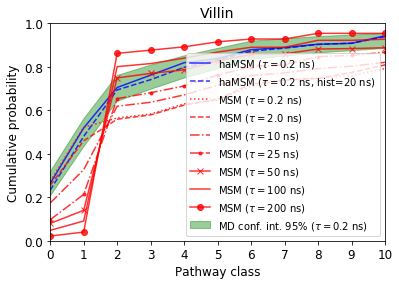

In [37]:
printmd("#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton")

alpha=0.8
x = list( range(len(mdFS)) )

plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD conf. int. 95% ($\tau=0.2$ ns)')
plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ ns)', color='blue', alpha=alpha)
plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ ns, hist=20 ns)', color='blue', alpha=alpha)

plt.plot(x, cdf(msmFSweights_temp),':', label = r'MSM ($\tau=0.2$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_10),'--', label = r'MSM ($\tau=2.0$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_50),'-.', label = r'MSM ($\tau=10$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_125),'-..', label = r'MSM ($\tau=25$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_250),'-x', label = r'MSM ($\tau=50$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_500),'c', label = r'MSM ($\tau=100$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_1000),'-o', label = r'MSM ($\tau=200$ ns)', color='red', alpha=alpha)


plt.xticks([i for i in range(0,2*len(mdFS),1)], fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,10])
plt.ylim([0,1.0])
plt.xlabel('Pathway class', fontsize=12)
plt.ylabel('Cumulative probability', fontsize=12)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()

plt.title('Villin', fontsize=14)

#plt.tight_layout()
plt.savefig('villin_FS.png', dpi=300)
plt.savefig('villin_FS.pdf')

plt.show()

# # Plot without MSM
# plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD Conf. Int. 95% ($\tau=0.2$ns)')
# plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ns)', color='blue', alpha=alpha)
# plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ns, hist=20ns)', color='blue', alpha=alpha)


# plt.xticks([i for i in range(0,2*len(mdFS),1)])
# plt.xlim([0,10])
# plt.ylim([0,1.0])
# plt.xlabel('Pathway Class', fontsize=14)
# plt.ylabel('Cumulative Probability', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.show()

### Plot

#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton

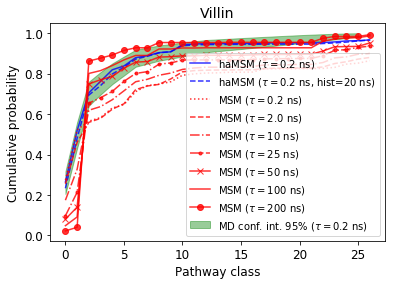

In [38]:
printmd("#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton")

alpha=0.8
x = list( range(len(mdFS)) )

plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD conf. int. 95% ($\tau=0.2$ ns)')
plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ ns)', color='blue', alpha=alpha)
plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ ns, hist=20 ns)', color='blue', alpha=alpha)

plt.plot(x, cdf(msmFSweights_temp),':', label = r'MSM ($\tau=0.2$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_10),'--', label = r'MSM ($\tau=2.0$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_50),'-.', label = r'MSM ($\tau=10$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_125),'-..', label = r'MSM ($\tau=25$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_250),'-x', label = r'MSM ($\tau=50$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_500),'c', label = r'MSM ($\tau=100$ ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_1000),'-o', label = r'MSM ($\tau=200$ ns)', color='red', alpha=alpha)


#plt.xticks([i for i in range(0,2*len(mdFS),1)])
#plt.xlim([0,10])
#plt.ylim([0,1.0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Pathway class', fontsize=12)
plt.ylabel('Cumulative probability', fontsize=12)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()

plt.title('Villin', fontsize=14)

#plt.tight_layout()
plt.savefig('villin_FS_full.png', dpi=300)
plt.savefig('villin_FS_full.pdf')

plt.show()

# # Plot without MSM
# plt.fill_between(x[:-1], mdmin, mdmax, color='green', alpha=0.4, label=r'MD Conf. Int. 95% ($\tau=0.2$ns)')
# plt.plot(x, cdf(nmFSweights_temp), label = r'haMSM ($\tau=0.2$ns)', color='blue', alpha=alpha)
# plt.plot(x, cdf(mcFSweights_temp), '--',label = r'haMSM ($\tau=0.2$ns, hist=20ns)', color='blue', alpha=alpha)


# plt.xticks([i for i in range(0,2*len(mdFS),1)])
# plt.xlim([0,10])
# plt.ylim([0,1.0])
# plt.xlabel('Pathway Class', fontsize=14)
# plt.ylabel('Cumulative Probability', fontsize=14)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.show()